# Спортивные сообщества VK

## _"Определить вид спорта по посту" (Задача классификации)_


Данные: https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification

## Часть 0. Введение

### Обзор

Данный датасет, как мы увидим здесь состоит из 3 колонок и 38740 строк.

**Метаданные**

* **oid** - id сообщества
* **category** - вид спорта (таргет)
* **text** - текст поста

### Контекст:
На основе заданного набора постов определите, какой вид спорта обсуждается в выбранном сообществе.

**Список категорий**

    1.athletics,
    2.autosport,
    3.basketball,
    4.boardgames,
    5.esport,
    6.extreme,
    7.football,
    8.hockey,
    9.martial arts,
    10.motosport,
    11.tennis,
    12.volleyball,
    13.winter_sport
    
### Оценочная метрика:

In [1]:
def score(true, pred, n_samples):
    counter = 0    
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

## Часть 1: Импорт, загрузка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

import re
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from gensim.models import word2vec

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



### Загрузка данных в датафрейм vk_sport

In [3]:
vk_sport = pd.read_csv('train.csv', encoding_errors = 'ignore')

## Часть 2. Анализ данных (EDA)

In [4]:
vk_sport.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [5]:
vk_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В таблице 3 колонки и 38740 строк.  
2 типа данных int64(1 колонка) и object(2 колонки)  
Пропущенных значений нет

In [6]:
vk_sport.describe(include=[object])

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


В колонке category - 13 уникальных значений.  
В колонке text - есть дублирующие тексты

In [7]:
# количество уникальных сообществ
vk_sport.oid.nunique()

3874

In [8]:
# есть ли сообщества с несколькими категориями?
vk_sport.groupby('oid').category.nunique().to_frame().query('category>1')

,category
oid,


Все сообщества в данном датасете имеют по одной категории

In [9]:
print('Количество классов:', vk_sport.category.nunique())
print('Распределение количества строк по категориям:')
vk_sport.category.value_counts()

Количество классов: 13
Распределение количества строк по категориям:


autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: category, dtype: int64

<AxesSubplot:>

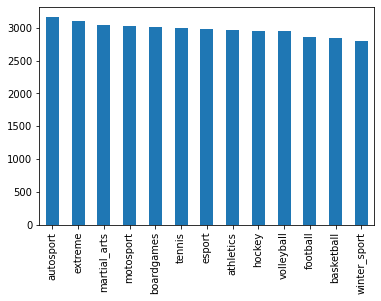

In [10]:
# визуализация распределения таргета "category"
vk_sport['category'].value_counts().plot(x = vk_sport['category'], kind='bar')

In [11]:
vk_sport['oid'].value_counts().unique()

array([10])

Имеем сбалансированный датасет

### Анализ колонки 'text'

In [12]:
# посмотрим на пример текста
vk_sport.at [406,'text']

'Коллеги традиционно объявляем очередной гильдейский настольныйсубботник ГРаНИ 33 По аналогии с индустрией компьютерных игр это предложение по субботам в течение дня выкладывать в комментарии к посту фото своих разработок с кратким описанием. А в ответ на выложенное другими интересоваться советовать предлагать сотрудничество и просто ставить лайки. Рассказывайте над чем сейчас работаете?'

В тексте есть слова содержащие 'tokenoid' - скорее всего являются заменой ссылок.
Есть слова на латинице.
А также цифры и пунктуация.  
Все слова написаны с применением разных регистров.


In [13]:
print(f"В колонке текст имеются дублирующие посты в количестве = {vk_sport['text'].shape[0] - vk_sport['text'].nunique()} строк")

В колонке текст имеются дублирующие посты в количестве = 2966 строк


Также в постах имеется реклама не по тематике спорта, например:

In [14]:
vk_sport.at [21139,'text']

'Плюс – это такой робот помощник который научит вас отдыхать в реальном не киберпанковом мире. Если вы сдали ЕГЭ на 80 и больше баллов получите подписку Яндекс Плюс бесплатно на целый год 33 Подробности здесь'

## Часть 3. Обработка и преобразование данных

### Разделение данных на train и test

In [15]:
train, test = train_test_split(vk_sport, test_size=0.25, random_state=42)

In [16]:
# размеры полученных датасетов
print(f'Размер датасетов train={len(train)}, test={len(test)}')

Размер датасетов train=29055, test=9685


### Приведем тексты постов к общему виду:
 - переводим символы в нижний регистр
 - удалим все слова цифры, пунктуацию и слова содержащие подстроку 'tokenoid'(видимо зашифрованы ссылки)

In [17]:
def clean_text(text):
    text = text.lower()
    # убираем цифры 
    clean_text = re.sub("[0-9]", "", text)
    # убираем ссылки
    clean_text = re.sub(r"([a-z]+)?tokenoid([a-z]+)?", "", text)
    # оставляем только буквенные символы
    clean_text = re.sub("[^а-яa-z]"," ", clean_text)
    # убираем лишние пробелы
    clean_text = re.sub(" +", " ", clean_text)
    return clean_text

In [18]:
# создаем колонку с преобразованным текстом
train['clean_text'] = train['text'].map(clean_text)

In [19]:
print(f"В колонке 'clean_text' количество дублирующих постов = {train['text'].shape[0] - train['clean_text'].nunique()} строк")

В колонке 'clean_text' количество дублирующих постов = 1886 строк


Посчитаем сколько раз каждый пост входит в датасет.
Рассмотрим посты, имеющие дубликаты

In [20]:
train['occurrence'] = train['clean_text'].map(dict(Counter( train['clean_text'].to_list())))

Посмотрим сколько раз дублируются посты.

In [21]:
train['occurrence'].unique()

array([  1,   2, 118,   9,  19,   3,  13,   8,   4,   5,   7,   6,  25,
        24,  10,  37,  11,  26,  14])

Рассмотрим в ручную каждые дубликаты, количество которых больше 3. Создадим список выражений, используемых в тексте реклам.

Например, какие посты были продублированы 13 раз в данном датасете.

In [22]:
train[train['occurrence']==13].head()

,oid,category,text,clean_text,occurrence
30941,211851544,extreme,Друзья кидайте в предложку свои фото и видео с...,друзья кидайте в предложку свои фото и видео с...,13
26439,676443746,boardgames,Приветствуем коллеги 33 А во что вы играли на ...,приветствуем коллеги а во что вы играли на про...,13
1834,933394281,boardgames,Приветствуем коллеги 33 А во что вы играли на ...,приветствуем коллеги а во что вы играли на про...,13
36330,211851544,extreme,Друзья кидайте в предложку свои фото и видео с...,друзья кидайте в предложку свои фото и видео с...,13
38024,702430194,football,Вам не нужно теперь ломать голову что подарить...,вам не нужно теперь ломать голову что подарить...,13


In [23]:
train.at [38024,'text']

'Вам не нужно теперь ломать голову что подарить на праздник. Порадуйте своих близких подарите им бурю эмоций 33 Цены снижены 33 Подробности здесь tokentokenoid'

In [24]:
train[train.clean_text.str.contains('что подарить')].occurrence.value_counts()

13    13
1      9
6      6
2      2
Name: occurrence, dtype: int64

In [25]:
advertisement_words = ['синергия','вакансия','подработка','кэшбэк','постель', 'аналитик данных',\
                       'профессия тестировщик','массажер','свою рекламу','что подарить','яндекс плюс',\
                       'яндекс еда','икеа','бесплатные курсы','бесплатного обслуживания','буст рейтинга',\
                       'ищете подарок']

### Удаление постов с рекламой

Проверяем есть ли выржание из списка и создаем колонку, маркирующую рекламу 1. Сохраняем датасет без рекламы.

In [26]:
def adv_posts(row,words_list):
    adv = 0
    for word in words_list:
        if word in row:
            adv = 1
    return adv

In [27]:
train['adv'] = train.clean_text.apply(lambda row: adv_posts(row,advertisement_words))

In [28]:
train[train.adv==1]

,oid,category,text,clean_text,occurrence,adv
3179,209435461,esport,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,4,1
14981,381255868,martial_arts,Да мы предлагаем вам оформить карту Ttokenoid ...,да мы предлагаем вам оформить карту с кэшбэком...,2,1
29862,435839274,volleyball,Альбом Votokenoid Sports Heatokenoid Resort – ...,альбом sports resort всесезонный семейный куро...,1,1
705,449610640,esport,ЗАКАЗ 95309 Буст рейтинга 1530 3780 Доп. опция...,заказ буст рейтинга доп опция выполнить быстре...,6,1
33491,209435461,esport,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,4,1
...,...,...,...,...,...,...
25184,671964543,extreme,С картой Wortokenoid of Tanks ваш прогресс в и...,с картой of tanks ваш прогресс в игре пойдет е...,1,1
13773,352942541,martial_arts,Да да это все вам. Бесплатная карта с бесплатн...,да да это все вам бесплатная карта с бесплатно...,5,1
24253,744276650,athletics,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,1,1
11653,364867243,esport,ЗАКАЗ 97956 Буст рейтинга 2940 3440 Доп. опция...,заказ буст рейтинга доп опция выполнить быстре...,6,1


In [29]:
train_no_adv = train[train.adv!=1]

### Удаление дубликатов

In [30]:
train_no_adv = train_no_adv.drop_duplicates(subset='clean_text')

In [31]:
print(f'Размер датасетов train={len(train)} и train_no_adv={len(train_no_adv)}')

Размер датасетов train=29055 и train_no_adv=27037


In [32]:
train_no_adv['category'].value_counts().unique()

array([2270, 2210, 2205, 2147, 2084, 2075, 2069, 2048, 2026, 2017, 1963,
       1875])

## Токенизация

In [33]:
import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

### Удаление стоп-слов

Список стоп-слов для русского языка из библиотеки nltk

In [34]:
from nltk.corpus import stopwords

stop_words_nltk = list(stopwords.words('russian'))

print('Количество стоп-слов библиотеки nltk =',len(stop_words_nltk))

Количество стоп-слов библиотеки nltk = 151


Список стоп слов для русского языка, взят из https://countwordsfree.com/stopwords/russian

In [35]:
# opening the file in read mode
my_file = open("stop_words_russian.txt", "r")
  
# reading the file
stopwords = my_file.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
stopwords_list = stopwords.split("\n")
print('Количество стоп-слов из countwordsfree.com =',len(stopwords_list))
my_file.close()

Количество стоп-слов из countwordsfree.com = 421


In [36]:
stop_words_of_sport = ['трансляция','видео','канал']
stopwords_list+=stop_words_of_sport

### Лемматизация

Лемматизация с помощью библиотеки pymorphy2

In [37]:
from pymorphy2 import MorphAnalyzer

lemmatyzer = MorphAnalyzer()

Напишем функцию разделяющее предложение на слова-токены, удаляющее стоп-слова и получающее список токенок лемм

In [38]:
def post_to_wordlist(post_sentence, remove_stopwords=False ):
    # разбиваем предложение на слова по символу пробела
    words = post_sentence.split()
    if remove_stopwords: # убираем стоп-слова
        words = [w for w in words if not w in remove_stopwords and len(w)>1]

    lemma_words = [lemmatyzer.parse(w)[0].normal_form for w in words]

    if remove_stopwords: # убираем стоп-слова
        lemma_words_nostops = [w for w in lemma_words if not w in remove_stopwords]

    return(lemma_words_nostops)

Модель разделения текста на предложения

In [39]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')



Функция разделяющая тексты постов на предложения и применяющая к ним функцию post_to_wordlist

In [40]:
def post_to_sentences(post, tokenizer, remove_stopwords=False):
    # разбиваем пост на предложения
    raw_sentences = tokenizer.tokenize(post.strip())
    sentences = []
    # применяем функцию post_to_wordlist к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(post_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [41]:
train_no_adv['tokenized_text'] = train_no_adv['clean_text'].apply(lambda row: post_to_wordlist(row, stopwords_list))
train_no_adv['lemmas_string'] = train_no_adv['tokenized_text'].apply(lambda row: ' '.join(row))

## Часть 4: Машинное обучение

In [42]:
def prepose_text(df_text):
    df_text['clean_text'] = df_text['text'].map(clean_text)
    df_text['adv'] = df_text.clean_text.apply(lambda row: adv_posts(row,advertisement_words))
    df_no_adv = df_text[df_text.adv!=1].drop_duplicates(subset='clean_text')
    df_no_adv['tokenized_text'] = df_no_adv['clean_text'].apply(lambda row: post_to_wordlist(row, stopwords_list))
    df_no_adv['lemmas_string'] = df_no_adv['tokenized_text'].apply(lambda row: ' '.join(row))
    return df_no_adv

In [43]:

test_no_adv = prepose_text(test)

In [77]:
X_train = train_no_adv['lemmas_string']
y_train = train_no_adv['category']

X_test = test_no_adv['lemmas_string']
y_test = test_no_adv['category']


In [45]:
X_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')

In [2]:
X_train = pd.read_csv('x_train.csv', index_col=0)
X_test = pd.read_csv('x_test.csv', index_col=0)

y_train = pd.read_csv('y_train.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

### Создаем таблицу метрик
Таблица с результатами полученных метрик для разных моделей

In [46]:
df_models_accuracy = pd.DataFrame(columns=['Название модели', 'Векторизатор текста', 'Accuracy'])

**Naive Bayes model - baseline -**

In [47]:
mnb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb_clf', MultinomialNB())])

mnb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb_clf', MultinomialNB())])

In [48]:
predicted_mnb = mnb_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_mnb, y_test))

              precision    recall  f1-score   support

   athletics       0.92      0.81      0.86       754
   autosport       0.90      0.79      0.84       887
  basketball       0.81      0.97      0.89       514
  boardgames       0.96      0.84      0.89       797
      esport       0.69      0.88      0.77       548
     extreme       0.75      0.68      0.71       816
    football       0.72      0.89      0.80       569
      hockey       0.89      0.86      0.88       777
martial_arts       0.75      0.84      0.79       616
   motosport       0.84      0.89      0.87       694
      tennis       0.97      0.92      0.94       784
  volleyball       0.87      0.82      0.85       793
winter_sport       0.88      0.85      0.87       729

    accuracy                           0.84      9278
   macro avg       0.84      0.85      0.84      9278
weighted avg       0.85      0.84      0.84      9278



In [49]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['Naive Bayes', 'TF-IDF', metrics.accuracy_score(predicted_mnb, y_test)]

In [50]:
df_models_accuracy

,Название модели,Векторизатор текста,Accuracy
0,Naive Bayes,TF-IDF,0.843285


**RandomForest model**

In [51]:
rf_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier())])

rf_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier())])

In [52]:
predicted_rf = rf_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

   athletics       0.91      0.89      0.90       675
   autosport       0.83      0.85      0.84       756
  basketball       0.82      0.89      0.85       566
  boardgames       0.93      0.91      0.92       714
      esport       0.75      0.66      0.70       791
     extreme       0.77      0.63      0.70       904
    football       0.73      0.74      0.73       696
      hockey       0.78      0.84      0.81       700
martial_arts       0.74      0.80      0.77       636
   motosport       0.85      0.88      0.86       709
      tennis       0.95      0.93      0.94       766
  volleyball       0.83      0.93      0.88       664
winter_sport       0.83      0.84      0.84       701

    accuracy                           0.82      9278
   macro avg       0.82      0.83      0.83      9278
weighted avg       0.82      0.82      0.82      9278



In [53]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['Random Forest', 'TF-IDF', metrics.accuracy_score(predicted_rf, y_test)]

**Стохастический градиентный спуск - SGD**

In [54]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])

sgd_ppl_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [55]:
predicted_sgd = sgd_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

   athletics       0.93      0.91      0.92       671
   autosport       0.88      0.88      0.88       779
  basketball       0.91      0.93      0.92       603
  boardgames       0.97      0.83      0.90       811
      esport       0.77      0.84      0.80       634
     extreme       0.75      0.81      0.78       694
    football       0.82      0.84      0.83       692
      hockey       0.85      0.92      0.88       706
martial_arts       0.83      0.83      0.83       682
   motosport       0.90      0.86      0.88       774
      tennis       0.97      0.95      0.96       771
  volleyball       0.91      0.91      0.91       743
winter_sport       0.91      0.89      0.90       718

    accuracy                           0.88      9278
   macro avg       0.88      0.88      0.88      9278
weighted avg       0.88      0.88      0.88      9278



In [56]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['SGDClassifier', 'TF-IDF', metrics.accuracy_score(predicted_sgd, y_test)]

**KNeighbors Model**

In [57]:
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

In [58]:
predicted_knb = knb_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

   athletics       0.92      0.68      0.78       887
   autosport       0.81      0.82      0.81       772
  basketball       0.85      0.80      0.82       656
  boardgames       0.94      0.86      0.90       764
      esport       0.72      0.76      0.74       661
     extreme       0.66      0.76      0.71       645
    football       0.71      0.81      0.76       616
      hockey       0.80      0.82      0.81       737
martial_arts       0.74      0.82      0.77       619
   motosport       0.84      0.86      0.85       720
      tennis       0.94      0.93      0.94       763
  volleyball       0.84      0.78      0.81       806
winter_sport       0.81      0.90      0.85       632

    accuracy                           0.81      9278
   macro avg       0.81      0.82      0.81      9278
weighted avg       0.82      0.81      0.81      9278



In [59]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['KNeighbors', 'TF-IDF', metrics.accuracy_score(predicted_knb, y_test)]

In [60]:
df_models_accuracy

,Название модели,Векторизатор текста,Accuracy
0,Naive Bayes,TF-IDF,0.843285
1,Random Forest,TF-IDF,0.823992
2,SGDClassifier,TF-IDF,0.877236
3,KNeighbors,TF-IDF,0.813322


In [62]:
from sklearn.model_selection import GridSearchCV
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'sgd_clf__alpha': (1e-2, 1e-3, 1e-4)
             }

search = GridSearchCV(sgd_ppl_clf, parameters)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.858):
{'sgd_clf__alpha': 0.0001, 'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True}


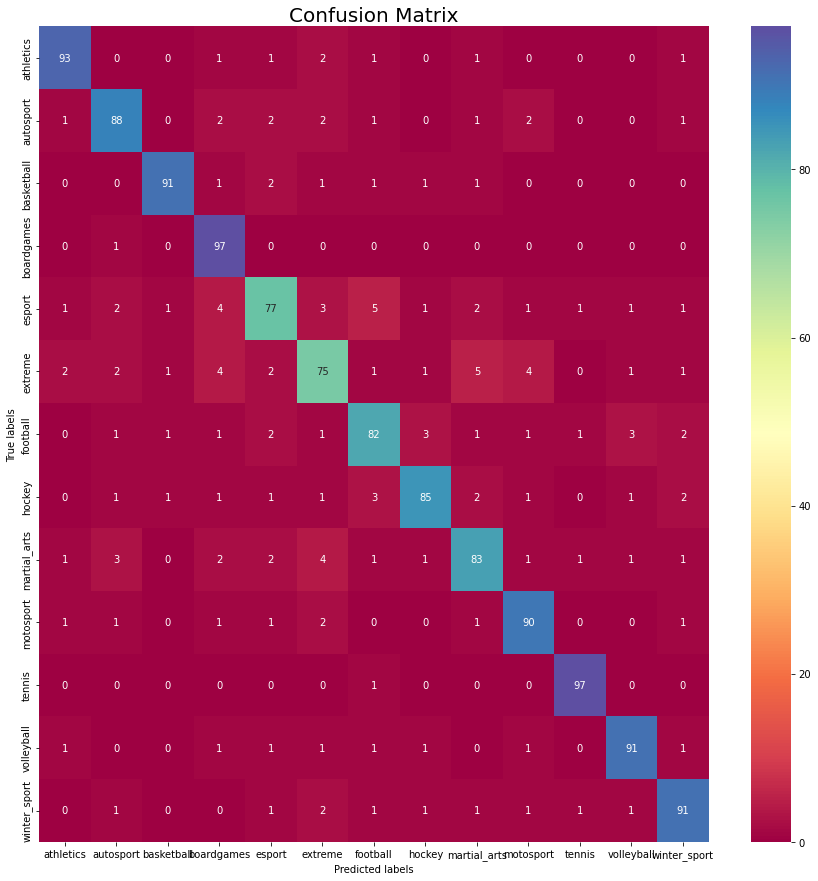

In [61]:
cmm = metrics.confusion_matrix(y_test, predicted_sgd, normalize='true')

lables = y_train.drop_duplicates()
T13_lables = sorted(lables)

plt.figure(figsize=(15, 15))

ax= plt.subplot()

sns.heatmap(np.rint(cmm*100), cmap="Spectral", annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix', fontdict={'fontsize':20}, pad=5); 
ax.xaxis.set_ticklabels(T13_lables); ax.yaxis.set_ticklabels(T13_lables);

## Нейронные сети

In [3]:
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, LSTM

from tensorflow.keras.callbacks import EarlyStopping

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Работа со временем
import time

%matplotlib inline

2023-08-14 15:53:19.065847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 15:53:19.412136: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 15:53:21.193929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
X_train = X_train['lemmas_string']
y_train = y_train['category']

X_test = X_test['lemmas_string']
y_test = y_test['category']

Для обучения нейронных сетей выделим из датасета train валидационные данные

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Создадим таблицу с данными моделями и полученной метрикой

In [6]:
df_nn_accuracy = pd.DataFrame(columns=['Название модели', 'Слои','Параметры', 'Accuracy'])

## Векторизация текста

In [10]:
# Посчитаем максимальную длину поста в словах
train_no_adv['tokenized_text']

max_words = 0
for post in train_no_adv['tokenized_text']:
    words = len(post)
    if words > max_words:
        max_words = words
print('Максимальная длина поста: {} слов'.format(max_words))


NameError: name 'train_no_adv' is not defined

In [7]:
from keras.preprocessing.text import Tokenizer

# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.tolist())

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
trainSequences = tokenizer.texts_to_sequences(X_train.tolist())
valSequences = tokenizer.texts_to_sequences(X_val.tolist())
testSequences = tokenizer.texts_to_sequences(X_test.tolist())

In [8]:
total_words = len(tokenizer.word_index)
print('В словаре {} слов'.format(total_words))

В словаре 51443 слов


In [9]:
# количество наиболее часто используемых слов
num_words = 10000

print(u'Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=num_words)
X_train_nn = tokenizer.sequences_to_matrix(trainSequences, mode='binary')
X_val_nn = tokenizer.sequences_to_matrix(valSequences, mode='binary')
X_test_nn = tokenizer.sequences_to_matrix(testSequences, mode='binary')
print('Размерность X_train для нейронной сети:', X_train_nn.shape)
print('Размерность X_val для нейронной сети:', X_val_nn.shape)
print('Размерность X_test для нейронной сети:', X_test_nn.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train для нейронной сети: (20277, 10000)
Размерность X_val для нейронной сети: (6760, 10000)
Размерность X_test для нейронной сети: (9278, 10000)


Оцифровываем названия категорий

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_nn = encoder.transform(y_train)
y_val_nn = encoder.transform(y_val)
y_test_nn = encoder.transform(y_test)

num_classes = np.max(y_train_nn) + 1
print('Количество категорий для классификации: {}'.format(num_classes))

Количество категорий для классификации: 13


In [11]:
print(u'Преобразуем категории в матрицу двоичных чисел '
      u'(для использования categorical_crossentropy)')
y_train_nn = utils.to_categorical(y_train_nn, 13)
y_val_nn = utils.to_categorical(y_val_nn, 13)
y_test_nn = utils.to_categorical(y_test_nn, 13)
print('Размеры y_train_nn:', y_train_nn.shape)
print('Размеры y_val_nn:', y_val_nn.shape)
print('Размеры y_test_nn:', y_test_nn.shape)

Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
Размеры y_train_nn: (20277, 13)
Размеры y_val_nn: (6760, 13)
Размеры y_test_nn: (9278, 13)


**MLP**

In [16]:
# количество эпох\итераций для обучения
epochs = 10

print(u'Собираем модель...')
model = Sequential()
model.add(Dense(512, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(13))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Собираем модель...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               5120512   
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 13)                6669      
                                                                 
 activation_3 (Activation)   (None, 13)                0         
                                                                 
Total params: 5127181 (19.56 MB)
Trainable params: 5127181 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________________

In [17]:
history = model.fit(X_train_nn, y_train_nn,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,validation_data=(X_val_nn, y_val_nn))

Epoch 1/10
634/634 [==============================] - 50s 77ms/step - loss: 0.9000 - accuracy: 0.7759 - val_loss: 0.5912 - val_accuracy: 0.8395
Epoch 2/10
634/634 [==============================] - 48s 75ms/step - loss: 0.2671 - accuracy: 0.9293 - val_loss: 0.6175 - val_accuracy: 0.8312
Epoch 3/10
634/634 [==============================] - 49s 77ms/step - loss: 0.1149 - accuracy: 0.9747 - val_loss: 0.6763 - val_accuracy: 0.8293
Epoch 4/10
634/634 [==============================] - 46s 73ms/step - loss: 0.0522 - accuracy: 0.9903 - val_loss: 0.7741 - val_accuracy: 0.8225
Epoch 5/10
634/634 [==============================] - 46s 73ms/step - loss: 0.0338 - accuracy: 0.9959 - val_loss: 0.8606 - val_accuracy: 0.8167
Epoch 6/10
634/634 [==============================] - 50s 79ms/step - loss: 0.0246 - accuracy: 0.9972 - val_loss: 0.9215 - val_accuracy: 0.8163
Epoch 7/10
634/634 [==============================] - 48s 76ms/step - loss: 0.0169 - accuracy: 0.9979 - val_loss: 0.9768 - val_accuracy:

In [18]:
score = model.evaluate(X_test_nn, y_test_nn,
                       batch_size=32, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

290/290 [==============================] - 5s 19ms/step - loss: 1.0387 - accuracy: 0.8286

Оценка теста: 1.038707971572876
Оценка точности модели: 0.8286268711090088


In [19]:
# добавляем первую полученную метрику в таблицу
df_nn_accuracy.loc[len(df_nn_accuracy.index)] = ['MLP', 'Dense(relu), Dropout, Dense(Softmax)','batch_size=32, epochs = 10', score[1]]

**LSTM**

In [20]:
maxSequenceLength = 353

In [21]:
X_train_lstm = utils.pad_sequences(X_train_nn, maxlen=maxSequenceLength)
X_val_lstm = utils.pad_sequences(X_val_nn, maxlen=maxSequenceLength)
X_test_lstm = utils.pad_sequences(X_test_nn, maxlen=maxSequenceLength)

print('Размерность X_train_lstm:', X_train_lstm.shape)
print('Размерность X_val_lstm:', X_val_lstm.shape)
print('Размерность X_test_lstm:', X_test_lstm.shape)

Размерность X_train_lstm: (20277, 353)
Размерность X_val_lstm: (6760, 353)
Размерность X_test_lstm: (9278, 353)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

# максимальное количество слов для анализа
max_features = 10000

print(u'Собираем модель...')
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, maxSequenceLength))
model_lstm.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(13, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model_lstm.summary())

Собираем модель...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 353)         3530000   
                                                                 
 lstm (LSTM)                 (None, 32)                49408     
                                                                 
 dense_4 (Dense)             (None, 13)                429       
                                                                 
Total params: 3579837 (13.66 MB)
Trainable params: 3579837 (13.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [23]:
batch_size = 32
epochs = 3

print(u'Тренируем модель...')
history = model_lstm.fit(X_train_lstm, y_train_nn,
                    batch_size=64,
                    epochs=epochs,
                    verbose=1,validation_data=(X_val_lstm, y_val_nn))

Тренируем модель...
Epoch 1/3
317/317 [==============================] - 280s 873ms/step - loss: 0.2995 - accuracy: 0.0788 - val_loss: 0.2715 - val_accuracy: 0.0743
Epoch 2/3
317/317 [==============================] - 395s 1s/step - loss: 0.2713 - accuracy: 0.0819 - val_loss: 0.2713 - val_accuracy: 0.0763
Epoch 3/3
317/317 [==============================] - 556s 2s/step - loss: 0.2714 - accuracy: 0.0794 - val_loss: 0.2712 - val_accuracy: 0.0825


In [24]:
score = model_lstm.evaluate(X_test_lstm, y_test_nn,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

290/290 [==============================] - 45s 154ms/step - loss: 0.2712 - accuracy: 0.0839

Оценка теста: 0.2711847126483917
Оценка точности модели: 0.08385428041219711


In [25]:
# добавляем первую полученную метрику в таблицу
df_nn_accuracy.loc[len(df_nn_accuracy.index)] = ['Embedding+LSTM', 'Embedding, LSTM, Dense(Sigmoid)','batch_size=32, epochs = 3', score[1]]

In [26]:
df_nn_accuracy

,Название модели,Слои,Параметры,Accuracy
0,MLP,"Dense(relu), Dropout, Dense(Softmax)","batch_size=32, epochs = 10",0.828627
1,Embedding+LSTM,"Embedding, LSTM, Dense(Sigmoid)","batch_size=32, epochs = 3",0.083854


### Подбор параметра количество нейронов и batch_size для MLP

In [ ]:
# количество эпох\итераций для обучения
epochs = 10

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 0,  restore_best_weights = True)

num_nets = [64, 128, 256, 512]
batch_sizes = [32, 64]

best_score = 0
best_num_net = 0
best_batch = 0

print('Поиск лучших параметров... ')

for num_net in num_nets:
    for batch_size in batch_sizes:
        
        model_2 = Sequential()
        model_2.add(Dense(num_net, input_shape=(num_words,)))
        model_2.add(Activation('relu'))
        model_2.add(Dropout(0.2))
        model_2.add(Dense(13))
        model_2.add(Activation('softmax'))

        model_2.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        history_2 = model_2.fit(X_train_nn, y_train_nn,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks = early_stopping,
                            verbose=1, validation_data=(X_val_nn, y_val_nn))

        score = model_2.evaluate(X_test_nn, y_test_nn,
                               batch_size=batch_size, verbose=1)
        print()
        print(f'Количество нейронов {num_net}, batch_size = {batch_size}')
        print(u'Оценка точности модели: {}'.format(score[1]))
        
        df_nn_accuracy.loc[len(df_nn_accuracy.index)] = ['MLP', 'Dense(relu), Dropout, Dense(Softmax)',f'batch_size={batch_size}, num_net = {num_net}', score[1]]

        if score[1]>best_score:
            best_score = score[1]
            best_num_net = num_net
            best_batch = batch_size
        


Поиск лучших параметров... 
Epoch 1/10
634/634 [==============================] - 10s 15ms/step - loss: 1.2042 - accuracy: 0.7265 - val_loss: 0.6735 - val_accuracy: 0.8379
Epoch 2/10
634/634 [==============================] - 8s 13ms/step - loss: 0.4592 - accuracy: 0.8891 - val_loss: 0.5758 - val_accuracy: 0.8438
Epoch 3/10
634/634 [==============================] - 8s 13ms/step - loss: 0.2733 - accuracy: 0.9359 - val_loss: 0.5723 - val_accuracy: 0.8395
Epoch 4/10
290/290 [==============================] - 1s 5ms/step - loss: 0.5476 - accuracy: 0.8518

Количество нейронов 64, batch_size = 32
Оценка точности модели: 0.8517999649047852
Epoch 1/10
317/317 [==============================] - 7s 19ms/step - loss: 1.4064 - accuracy: 0.7018 - val_loss: 0.7835 - val_accuracy: 0.8318
Epoch 2/10
317/317 [==============================] - 6s 18ms/step - loss: 0.5676 - accuracy: 0.8747 - val_loss: 0.6064 - val_accuracy: 0.8425
Epoch 3/10
317/317 [==============================] - 5s 17ms/step - los

In [ ]:
print(f'Лучшая точность равная {best_score} получается при количестве нейронов = {best_num_net} и batch_size={best_batch} ')